# Variational Autoencoder (VAE)

Useful links: 
* original paper http://arxiv.org/abs/1312.6114
* helpful videos explaining the topic 
   * https://www.youtube.com/watch?v=P78QYjWh5sM     
   * http://videolectures.net/deeplearning2015_courville_autoencoder_extension/?q=aaron%20courville

In this seminalr we will train an autoencoder to model images of faces. For this we take "Labeled Faces in the Wild" dataset (LFW) (http://vis-www.cs.umass.edu/lfw/), deep funneled version of it. (frontal view of all faces)


## Prepare the data

In [5]:
import numpy as np
from lfw_dataset import fetch_lfw_dataset
from sklearn.model_selection import train_test_split
X, attr = fetch_lfw_dataset(use_raw=True,dimx=38,dimy=38)
X = X.astype('float32') / 255.0

X_train, X_val = train_test_split(X, test_size=0.1,random_state=42)

In [20]:
print(X_train.shape, X_val.shape)

(11828, 38, 38, 3) (1315, 38, 38, 3)


For simplicity we want all values of the data to lie in the interval $[0,1]$:

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_gallery(images, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.5 * n_col, 1.7 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w, 3)), cmap=plt.cm.gray, vmin=-1, vmax=1, interpolation='nearest')
        plt.xticks(())
        plt.yticks(())

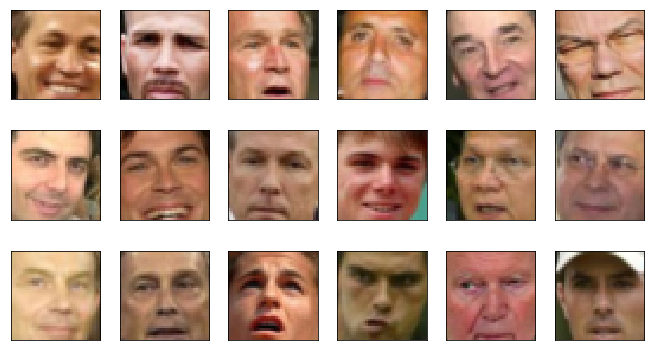

In [11]:
plot_gallery(X_train, 38, 38)

In [12]:
import tensorflow as tf
import keras, keras.layers as L
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras import backend as K
K.set_session(sess)

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


# Variational Autoencoder


In [22]:
img_shape = X_train.shape[1:]
code_size = 32
print(img_shape)

(38, 38, 3)


In [47]:
def splittensor(axis=1, ratio_split=1, id_split=0, **kwargs):
    def f(X):
        div = int(X.shape[axis] // ratio_split)
        if axis == 0:
            output = X[id_split * div:(id_split + 1) * div, :]
        elif axis == 1:
            output = X[:, id_split * div:(id_split + 1) * div]
        else:
            raise ValueError('This axis is not possible')
        return output
    def g(input_shape):
        output_shape = list(input_shape)
        output_shape[axis] = output_shape[axis] // ratio_split
        return tuple(output_shape)
    return L.Lambda(f, output_shape=lambda input_shape: g(input_shape), **kwargs)

enc_input = L.Input(shape=img_shape, name='enc_input')

enc_conv1 = L.Conv2D(filters=16, kernel_size=(4,4), 
                             strides=(2,2),activation='elu', name='enc_conv1')(enc_input)

enc_conv2 = L.Conv2D(filters=32, kernel_size=(4,4), 
                      strides=(2,2),activation='elu',name='enc_conv2')(enc_conv1)

enc_conv3 = L.Conv2D(filters=64, kernel_size=(3,3), padding='same',
                      strides=(2,2),activation='elu',name='enc_conv3')(enc_conv2)

enc_flatten = L.Flatten(name='enc_flatten')(enc_conv3)

enc_dense = L.Dense(code_size*2, activation='elu',name='code_dense')(enc_flatten)
    
mean = splittensor(axis=1, ratio_split=2, id_split=0, name='mean')(enc_dense)
    
log_var = splittensor(axis=1, ratio_split=2, id_split=1, name='log_var')(enc_dense)
    
code = L.Lambda(lambda params:\
                params[0] + (params[1] / 2) * K.random_normal(shape=K.shape(params[0]), mean=0.0, stddev=1.0),
                output_shape=(code_size,))([mean, log_var])
                   
  
enc = keras.models.Model(inputs=enc_input,outputs=[code,mean,log_var],name='encoder')
    

dec_input = L.Input((code_size,),name='dec_input')
   
dec_dense = L.Dense(1024, activation='elu',name='dec_input_dense')(dec_input)
    
dec_reshape = L.Reshape((4,4,64),name='dec_reshape')(dec_dense)

deconv1= L.Conv2DTranspose(filters=32, kernel_size=(3,3), strides=(2,2),
                                    activation='elu', padding='same',name='dec_deconv1')(dec_reshape)

deconv2 = L.Conv2DTranspose(filters=16, kernel_size=(4,4), strides=(2,2),
                                      padding='valid',activation='elu',name='dec_deconv2')(deconv1)
    
deconv3 = L.Conv2DTranspose(filters=16, kernel_size=(4,4), strides=(2,2),
                                activation='elu',name='dec_deconv3')(deconv2)
    
dec_output = L.Conv2D(filters=3, kernel_size=(1,1),padding='same',
                          activation='sigmoid',name='dec_output')(deconv3)
    
dec = keras.models.Model(inputs=dec_input,outputs=dec_output,name='decoder')

print(enc.summary())
print(dec.summary())


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
enc_input (InputLayer)           (None, 38, 38, 3)     0                                            
____________________________________________________________________________________________________
enc_conv1 (Conv2D)               (None, 18, 18, 16)    784         enc_input[0][0]                  
____________________________________________________________________________________________________
enc_conv2 (Conv2D)               (None, 8, 8, 32)      8224        enc_conv1[0][0]                  
____________________________________________________________________________________________________
enc_conv3 (Conv2D)               (None, 4, 4, 64)      18496       enc_conv2[0][0]                  
___________________________________________________________________________________________

In [49]:
inp = L.Input(img_shape)
code,mean,log_var = enc(inp)
reconstruction = dec(code)


def vae_loss(mean, log_var):
    def nested_function(data, reconstructed):
        dec_loss = keras.metrics.mae(data, reconstructed)
        kl_loss = 0.5 * K.mean(K.sum(K.square(mean) + K.exp(log_var) - log_var - 1, axis=-1))
        return dec_loss + kl_loss
    return nested_function

vae = keras.models.Model(inp,reconstruction)
print(vae.summary())
opt=keras.optimizers.Adam(lr=0.001)
vae.compile(opt,loss=vae_loss(mean, log_var))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 38, 38, 3)         0         
_________________________________________________________________
encoder (Model)              [(None, 32), (None, 32),  93104     
_________________________________________________________________
decoder (Model)              (None, 38, 38, 3)         64627     
Total params: 157,731
Trainable params: 157,731
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
vae.fit(x=X_train,y=X_train,epochs=20,batch_size = 64,
                validation_data=[X_val,X_val])

Train on 11828 samples, validate on 1315 samples
Epoch 1/20
11828/11828 [==============================] - 1s - loss: 0.1598 - val_loss: 0.1113
Epoch 2/20
11828/11828 [==============================] - 1s - loss: 0.1000 - val_loss: 0.0915
Epoch 3/20
11828/11828 [==============================] - 1s - loss: 0.0865 - val_loss: 0.0827
Epoch 4/20
11828/11828 [==============================] - 1s - loss: 0.0795 - val_loss: 0.0778
Epoch 5/20
11828/11828 [==============================] - 1s - loss: 0.0753 - val_loss: 0.0722
Epoch 6/20
11828/11828 [==============================] - 1s - loss: 0.0696 - val_loss: 0.0681
Epoch 7/20
11828/11828 [==============================] - 1s - loss: 0.0665 - val_loss: 0.0654
Epoch 8/20
11828/11828 [==============================] - 1s - loss: 0.0642 - val_loss: 0.0639
Epoch 9/20
11828/11828 [==============================] - 1s - loss: 0.0629 - val_loss: 0.0624
Epoch 10/20
11828/11828 [==============================] - 1s - loss: 0.0617 - val_loss: 0.0616


In [51]:
def visualize(img,encoder,decoder,all_in_one_flag = False):
    """Draws original, encoded and decoded images"""
    code, mean, log_var= encoder.predict(img[None])
    code = code.reshape(32)
    if all_in_one_flag:
        reco = decoder.predict(img[None])[0]
    else:
        reco = decoder.predict(code[None])[0]
      
    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1))
    plt.show()

Final MSE: 0.0585488255033


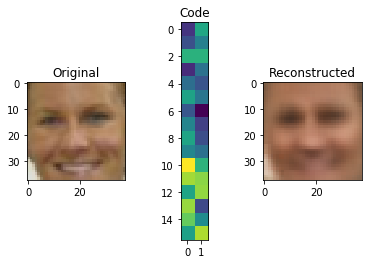

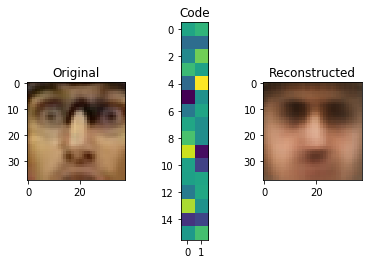

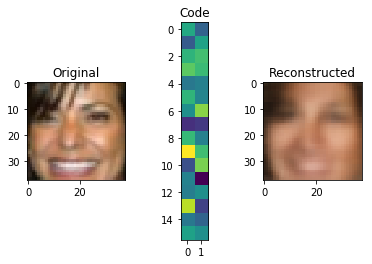

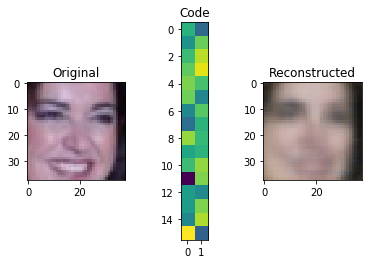

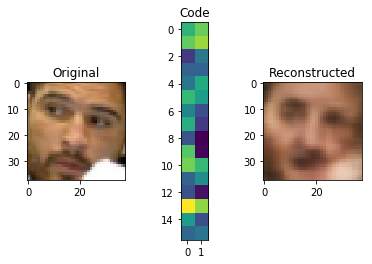

In [52]:
reconstruction_mse = vae.evaluate(X_val,X_val,verbose=0)
print("Final MSE:", reconstruction_mse)
for i in range(5):
    img = X_val[i]
    visualize(img,enc,dec)

# Congrats!

If you managed to tune your autoencoders to converge and learn something about the world, now it's time to make fun out of it. As you may have noticed, there are labels in dataset, some unknown real values, face attribute. Here is the first task:

1) Sort by the attribute and find out what it is about.

In [ ]:
attrs[:10]
#You're after "Smiling" column, but feel free to try others as well!

In [ ]:
#show top- and bottom-10 faces of sorted

2) Take z-representations of those top images (you can do it only for positive of for both) and average them to find **"vector representation"** of the attribute.

3) Show how **"feature arithmetics"** works with representations of both VAE and conventional autoencoder. Show how to generate an image with preconditioned attribute. Take some sad faces and make them smiling.

4) (If you didn't manage to tune VAE, just show if it works for just AE.) Discuss the results.

<img src="linear.png" alt="linear">